# Jonathan Polakow
# ST10081881
# PDAN8412 POE

This is the Jupyter Notebook code for my PDAN8412 POE submission. All the code below was created with the goal of completing all the requirements set out by the assignments instructions and rubric. 
The rational, details, justifications, and processes are all outlined in detail in the accompanying PDF document. Despite the amount of detailed comments about each section it is recommended to read the document inorder to gain a better understanding of this Jupyter Notebook.

In [1]:
###############################################################################################################################################################
#----------------------------------------------------------------------SETUP-----------------------------------------------------------------------------------
###############################################################################################################################################################

In [ ]:
#Imports
#PySpark data handeling imports
from pyspark.sql import SparkSession, Row #Data handeling and preprocessing
from pyspark.sql.functions import regexp_replace, when, col #Data prepocessing

#Tensorflow & keras model imports
import tensorflow as tf #TensorFlow
from tensorflow.keras import layers, models, regularizers #Imports to enable CNNs
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping #Model optimisation
from tensorflow.keras.applications import VGG16 #Transferlearning import
from tensorflow.keras.models import load_model #Used to load a saved Keras model

#SKLearn data handeling imports
from sklearn.model_selection import train_test_split #dataset splitting
from sklearn.metrics import confusion_matrix #Model evaluations

#Data Visualisation imports
import seaborn as sns #Graphing
import matplotlib.pyplot as plt #Graphing

#Other imports
import numpy as np #Data handeling / storage
from PIL import Image #Pythons image library, used for EDA
import random #Random numbers

In [3]:
#Enviomental variables

#Solves the following envioment error:
#   "Python in worker has different version 3.10 than that in driver 3.11, PySpark cannot run with different minor versions. 
#       Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set."

import sys
import os

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [4]:
#Create new spark session
spark = SparkSession.builder.appName("ImageProcessing").getOrCreate()

In [5]:
###############################################################################################################################################################
#----------------------------------------------------------------------DATA LOADING & PREPROCESSING------------------------------------------------------------
###############################################################################################################################################################

In [6]:
#Get image attributes from CSV using spark
labels_df = spark.read.csv("list_attr_celeba.csv", header=True, inferSchema=True)
labels_df = labels_df.select("image_id", "Smiling")
labels_df = labels_df.withColumn("image_id", regexp_replace("image_id", ".jpg", ""))

#Normalise smiling label to be binery and not -1 and 1
#If the values is >= to 0 then the values is set to 1, else the value is 0
#This covnerts the -1 for negative to 0 and the 1 for positive stays the same
smiling_norm = when(col("Smiling") >= 0, 1).otherwise(0)
labels_df = labels_df.withColumn("Smiling", smiling_norm)

#Check
labels_df.printSchema()
labels_df.show(5)

root
 |-- image_id: string (nullable = true)
 |-- Smiling: integer (nullable = false)

+--------+-------+
|image_id|Smiling|
+--------+-------+
|  000001|      1|
|  000002|      1|
|  000003|      0|
|  000004|      0|
|  000005|      0|
+--------+-------+
only showing top 5 rows



In [7]:
#Get image file paths
image_dir = "images"

#Create a two dimensional list of the image ID and the image path
image_files = [(filename.split('.')[0], os.path.join(image_dir, filename)) for filename in \
               os.listdir(image_dir) if filename.endswith('.jpg')]

#Sample only a certain number to reduce computational cost and time
sampling_count = 100000
image_files = image_files[:sampling_count]

#Convert list to spark dataframe
images_df = spark.createDataFrame([Row(image_id=img[0], image_path=img[1]) for img in image_files])

#Check
images_df.printSchema()
images_df.show(5)

root
 |-- image_id: string (nullable = true)
 |-- image_path: string (nullable = true)

+--------+-----------------+
|image_id|       image_path|
+--------+-----------------+
|  000001|images\000001.jpg|
|  000002|images\000002.jpg|
|  000003|images\000003.jpg|
|  000004|images\000004.jpg|
|  000005|images\000005.jpg|
+--------+-----------------+
only showing top 5 rows



In [8]:
#Merge image paths with their corresponding class labels
#Creates a new spark dataframe with the image_path and its class label
#Although there are no nulls or duplicates just to be safe any nulls and duplicates are dropped
labeled_images_df = images_df.join(labels_df, on="image_id")
labeled_images_df = labeled_images_df.select("image_path", "Smiling")
labeled_images_df = labeled_images_df.dropna()
labeled_images_df = labeled_images_df.dropDuplicates()
labeled_images_df.printSchema()
labeled_images_df.show(5)

root
 |-- image_path: string (nullable = true)
 |-- Smiling: integer (nullable = false)

+-----------------+-------+
|       image_path|Smiling|
+-----------------+-------+
|images\000334.jpg|      1|
|images\000359.jpg|      1|
|images\000683.jpg|      0|
|images\000911.jpg|      1|
|images\000939.jpg|      0|
+-----------------+-------+
only showing top 5 rows



In [9]:
###############################################################################################################################################################
#----------------------------------------------------------------------EXPLORATORY DATA ANALYSIS---------------------------------------------------------------
###############################################################################################################################################################

In [10]:
#Create copy of the dataframe using pandas 
#Pandas is used for easier interaction and graphing of the data
labeled_images_pd = labeled_images_df.toPandas()

Not Smiling & Smiling counts:
Smiling
0    52154
1    47845
Name: count, dtype: int64



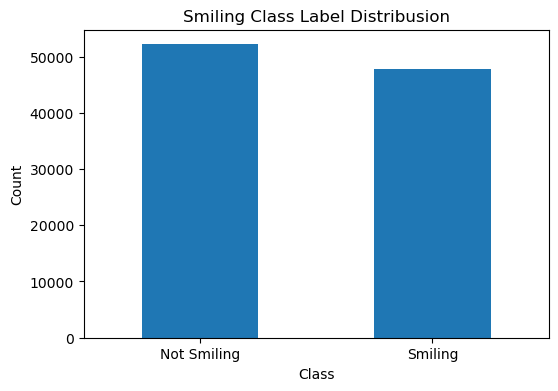

In [11]:
#Output class label data distribusion
#The accompanying PDF document contains explanations of why this is done and the resulting findings

#Get class label distribusion
smiling_counts = labeled_images_pd['Smiling'].value_counts()
print(f"Not Smiling & Smiling counts:\n{smiling_counts}\n")

#Create bar chart to visualise the distribusion
plt.figure(figsize=(6, 4))
smiling_counts.plot(kind='bar', title="Smiling Class Label Distribusion")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ['Not Smiling', 'Smiling'], rotation=0)
plt.show()

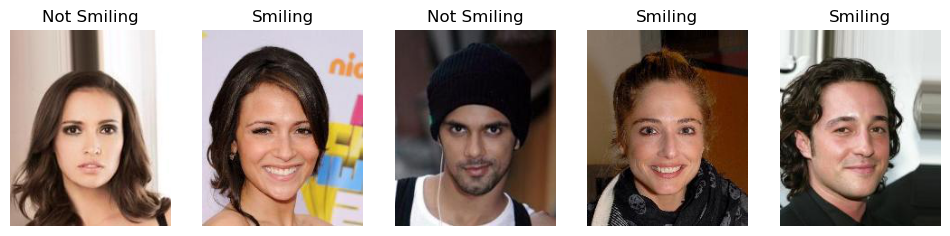

In [19]:
#Show random images with their labels
#The accompanying PDF document contains justifications and rational of why this is done

#Get 5 random image paths
sample_images = random.sample(list(labeled_images_pd[['image_path', 'Smiling']].values), 5)

plt.figure(figsize=(12, 6))

#Load the images
for i, (img_path, classlabel) in enumerate(sample_images):
    #Get label
    if classlabel == 0:
        label = 'Not Smiling'
    else:
        label = 'Smiling'

    #Using pythons image library to load the images
    img = Image.open(img_path)
    #Add image to the subploy
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"{label}")
    plt.axis('off')

plt.show()

In [13]:
###############################################################################################################################################################
#----------------------------------------------------------------------CREATING THE PIPELINE-------------------------------------------------------------------
###############################################################################################################################################################

In [ ]:
#Data processing functions
#These functions work together inorder to load the images and their paired labels.
#Flow of the data processing for the model training pipeline:
#   the create_tf_datasets() function is called
#   create_tf_datasets() splits the data into training, validation and testing
#   create_tf_datasets() creates the training data but calling the data_generator() function
#       This is done is batches, determined by the .prefetch(tf.data.AUTOTUNE) paramiter, to prevent high memory usage
#   data_generator() takes every image_path and label combination and passes them to load_and_preprocess_image()
#   load_and_preprocess_image() then loads and proprocesses the image, it then returns the image file and label to data_generator()
#   data_generator() returns the list of the images and their labels
#   create_tf_datasets() repeats this process until all the images for each dataset has been loaded
#   create_tf_datasets() then returns each dataset

#Further details, justifications and rational of these functions, the pipeline and the flow can be found in the accompanying PDF document

#Function to load and preprocess images
#This is used to get every image file and its correct label
def load_and_preprocess_image(file_path, label, augment=True):
    img = tf.io.read_file(file_path) #Load the image in the file path, loads as bytes not a file
    img = tf.io.decode_jpeg(img, channels=3) #Decodes the bytes back into the image
    img = tf.image.resize(img, [128, 128]) #Resizes the image
    img = img / 255.0 #Normalised the scale of the pixels to 0 and 1 instead of 0 and 255
    return img, label #Returns the image and corresponding label

#Function to load the image paths and labels in batches rather than all at once
#Formats the data in a manner that makes the first feature act as an X/input and the second feature be the Y/output
def data_generator(data):
    #Retreives the image files and the labels from the load_and_preprocess_image function
    for image_path, label in data:
        yield load_and_preprocess_image(image_path, label)

#Function to create the three datasets in TensorFlow datasets
#Uses the data_generator function as a python generator inorder to retreive the data in batches
#Training and validation are used while the model is training and testing is used as the new out-of-sample unseen data
def create_tf_datasets(data, test_size=0.3, val_size=0.2, random_state=42, batch_size=128):
    
    #Split the data into train, validation and test sets
    #This is done differently than usual as I wanted to see what would happen if I tried to apply the theory learnt in DANA8412
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=random_state) 
    val_data, test_data = train_test_split(test_data, test_size=val_size, random_state=random_state)
    
    #Training dataset
    #Use the data generator to load the data in batches
    train_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(train_data), #Gets every image and label pair
        output_signature=( #Specifies the expected output
            tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32), #The shape and the type of the images
            tf.TensorSpec(shape=(), dtype=tf.int32) #The type of the labels
        )
        #Shuffle shuffles the dataset in 1000 increments
        #Batch specifies how many entries in every batch
        #Prefetch tells TensorFlow to load the entries in the background in groups, the size is automatically calculated
    ).repeat().shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE) 

    #Validation dataset
    #The code works the same as above
    val_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(val_data),
        output_signature=(
            tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
        #As the data size is smaller prefetch and shuffle are not needed
    ).repeat().batch(batch_size)

    #Testing dataset
    #The code works the same as above
    test_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(test_data),
        output_signature=(
            tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
        #As the data size is smaller prefetch and shuffle are not needed
    ).batch(batch_size)

    return train_dataset, val_dataset, test_dataset

In [15]:
#Model functions
#These functions work together inorder to create a model, compile it, train it, then evalauate it
#Flow for the model training pipeline:
#   The pipeline calles the train_model() function and passes it the model type and the required data
#   train_model() creates the correct model using the model types create model function
#   The create model functions declare the CNN model, compliles it, then returns the compiled model
#   train_model() declares the callbacks then fits the model with the correct parameters whilst saving the models training history
#   train_model() then returns the trained model and its training history to the pipeline
#   The pipeline then calls evaluate_model() and passes it the model, testing dataset and the models history
#   evaluate_model() then prints the models training evaluations, its testing evaluations and evaluation graphs
#       The training evaluations include the modls final training and validation scores 
#       The testing evaluations are the loss and accuracy scores of the model using the testing dataset
#       The evaluation graphs include the models training loss and accuracy curves and a confusion matrix of the testing data

#Further details, justifications and rational of these functions, the pipeline and the flow can be found in the accompanying PDF document

#Function to return a CNN model with two convolutional layers
#This creates a very basic model with two convolutional layers and pooling layers, one fully connected layer and one output layer
#The model is complied with the adam optimizer, it uses binary_crossentropy to calculate its loss, and also prints it accuracy
def create_two_conv_cnn_model():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Function to return a CNN model with three convolutional layers
#This creates a simple model with three convolutional layers and pooling layers, one fully connected layer and one output layer
#The model is complied with the adam optimizer, it uses binary_crossentropy to calculate its loss, and also prints it accuracy
def create_three_conv_cnn_model():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Function to return a CNN model with four convolutional layers
#This creates a simple model with four convolutional layers, three pooling layers, one fully connected layer and one output layer
#The model is complied with the adam optimizer, it uses binary_crossentropy to calculate its loss, and also prints it accuracy
def create_four_conv_cnn_model():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Function to return a CNN model with five convolutional layers
#This creates a simple model with five convolutional layers, four pooling layers, one fully connected layer and one output layer
#The model is complied with the adam optimizer, it uses binary_crossentropy to calculate its loss, and also prints it accuracy
def create_five_conv_cnn_model():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


#Function to return a CNN model with L2 regularization
#This creates a simple model with four convolutional layers, three pooling layers, one fully connected layer and one output layer
#Every convolutional layer and the fully connected layer have L2 regularisation to prevent overfitting
#The model is complied with the adam optimizer, it uses binary_crossentropy to calculate its loss, and also prints it accuracy
def create_four_conv_cnn_model_with_regularisation():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Function to return a CNN model with two fully connected layers and L2 regularization
#This creates a more compelx model with four convolutional layers, three pooling layers, two fully connected layers and one output layer
#Every convolutional layer and the two fully connected layers have L2 regularisation to prevent overfitting
#The model is complied with the adam optimizer, it uses binary_crossentropy to calculate its loss, and also prints it accuracy
def create_duel_layered_cnn_model_with_regularisation():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Function to return a CNN model with added data augmentation and regularization
#This creates a simple model with data augmentation, four convolutional layers, three pooling layers, one fully connected layer and one output layer
#Every convolutional layer and the fully connected layer have L2 regularisation to prevent overfitting
#There are added keras layers that are responsible for randomly augmenting images every epoch
#The model is complied with the adam optimizer, it uses binary_crossentropy to calculate its loss, and also prints it accuracy
def create_four_conv_cnn_model_with_augmentation_and_regularization():
    model = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


#Function to train the model
#The model type is received, the model created, given callbacks, fitted to the data and then returned
def train_model(model_type, train_dataset, val_dataset, epochs=20, batch_size=128):
   
    #Callback functions to prevent overfitting and encorage better convergence
    #A more in-depth explanation of why these callbacks were chosen and what they are 
    # can be found in the accompanying PDF document
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    #Define steps per epoch as the training and val data repeats, helps to prevent endless training
    steps_per_epoch = int((sampling_count*0.7) // batch_size)
    val_steps_per_epoch = int(((sampling_count*0.3)*0.8) // batch_size)

    #Create the model
    model = model_type()

    #The model is then fitted to train
    history = model.fit(
        train_dataset, 
        validation_data=val_dataset, 
        epochs=epochs, 
        steps_per_epoch=steps_per_epoch,
        validation_steps=val_steps_per_epoch,
        callbacks=[lr_scheduler, early_stopping])
    
    #If the model is the one found to be the best one then save it as a keras file
    #This is done for the user input
    if model_type == create_duel_layered_cnn_model_with_regularisation:
        model.save('ST10081881_best_model.keras')

    return model, history

#Function to evaluate the model
#Creates evaluations scores and graphs to easily interprete the models performance and 
#   generalisation ability
def evaluate_model(model, test_dataset, history):
    #Each visualsiation is explaned in the accompanying PDF document

    #Create model predictions on the testing dataset for evaluations
    y_true = []
    y_pred = []
    for images, labels in test_dataset:
        y_true.extend(labels.numpy())
        #feed the model the inputs and tell it not to train, so its only createing predicitons  
        y_pred.extend((model(images, training=False) > 0.5).numpy().astype(int).flatten())

    #Calculate accuracy scores
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    test_accuracy = np.mean(y_true == y_pred)

    #Print the models last epochs results
    print(f"Final Training Loss: {history.history['loss'][-1]}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    #Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=['Not Smiling', 'Smiling'], yticklabels=['Not Smiling', 'Smiling'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    #Plot training accuracy and loss curves for the taining and validation datasets
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.xticks(epochs)
    plt.legend()
    plt.show()

    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.show()

In [16]:
#Pipeline
#This function is the programs pipeline as it takes in the data and what model to use, then automatically processes the data, 
#   fits the data to the model, trains the model, then evaluates the model
#Justifications and rational for the pipeline, and an explanation of what pipelines are can be found in the accompanying PDF document
def model_pipeline(data, model_type):
    
    #Load and process the data
    #Loads images, assigned labels, and creates TensorFlow datasets with batches
    train_dataset, val_dataset, test_dataset = create_tf_datasets(data)
    
    #Fit the model
    #Creates the model, trains it, ten returns the model and its training history
    model, history = train_model(model_type, train_dataset, val_dataset, epochs=20)

    #Evaluate the model
    #Prints multiple evaluation scores and graphs
    evaluate_model(model, test_dataset, history)

In [17]:
###############################################################################################################################################################
#----------------------------------------------------------------------APPLYING THE PIPELINES------------------------------------------------------------------
###############################################################################################################################################################

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 306s 553ms/step - accuracy: 0.7555 - loss: 0.4954 - val_accuracy: 0.9058 - val_loss: 0.2283 - learning_rate: 0.0010
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 230s 421ms/step - accuracy: 0.9006 - loss: 0.2453 - val_accuracy: 0.9121 - val_loss: 0.2123 - learning_rate: 0.0010
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 229s 420ms/step - accuracy: 0.9130 - loss: 0.2197 - val_accuracy: 0.9139 - val_loss: 0.2100 - learning_rate: 0.0010
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 230s 422ms/step - accuracy: 0.9175 - loss: 0.2048 - val_accuracy: 0.9124 - val_loss: 0.2141 - learning_rate: 0.0010
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 229s 419ms/step - accuracy: 0.9236 - loss: 0.1864 - val_accuracy: 0.9144 - val_loss: 0.2092 - learning_rate: 0.0010
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 222s 406ms/step - accuracy: 0.9280 - loss: 0.1748 - val_accuracy: 0.9146 - val_loss: 0.2160 - learning_rate: 0.0010
Epoch 7/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy

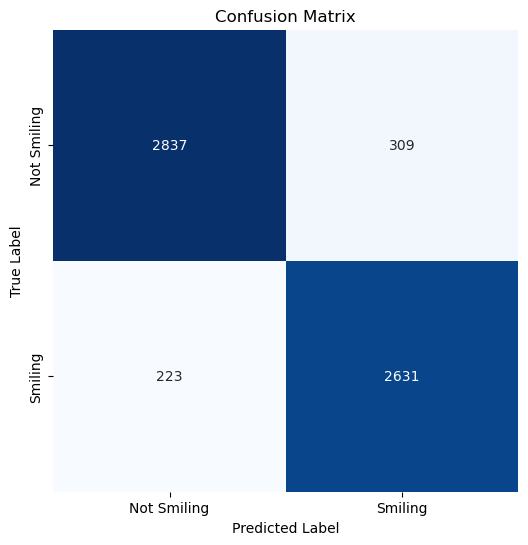

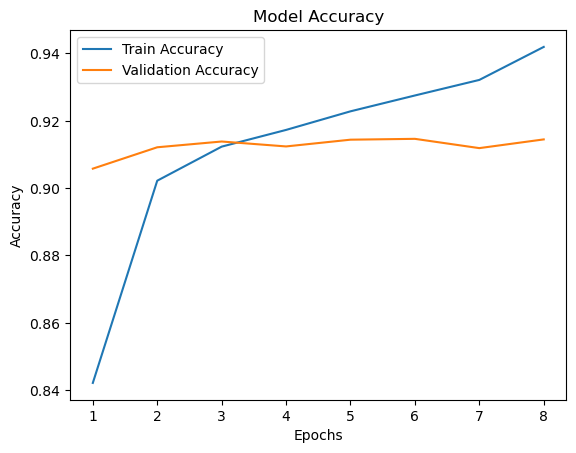

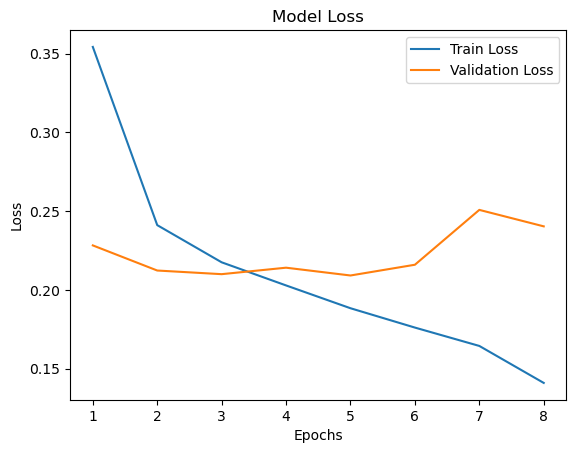

In [18]:
#CNN model with two convolutional layers
#The components, definition and indepth explanation of how CNN model work can be found in the accompanying PDF document
try:
    model_pipeline(labeled_images_df.collect(), create_two_conv_cnn_model)
except Exception as e:
    print("An error occurred:", e)

#---Evaluation metrics---
#Final Training Loss:           0.17
#Final Training Accuracy:       0.93
#Final Validation Loss:         0.21
#Final Validation Accuracy:     0.91
#Out-Of-Sample Test Accuracy:   0.92
#Accuracy training curve:       Shows training improving faster than validation 
#                                   and slight divergence at the final epochs
#Loss training curve:           Shows the model is overfitting
#Confusion matrix:              Shows high per class accucacy
#Overall findings: Good model results but it is overfitting and can be improved

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 260s 471ms/step - accuracy: 0.7734 - loss: 0.4345 - val_accuracy: 0.9110 - val_loss: 0.2114 - learning_rate: 0.0010
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 247s 452ms/step - accuracy: 0.9097 - loss: 0.2184 - val_accuracy: 0.9164 - val_loss: 0.1987 - learning_rate: 0.0010
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 243s 445ms/step - accuracy: 0.9177 - loss: 0.2006 - val_accuracy: 0.9159 - val_loss: 0.1939 - learning_rate: 0.0010
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 242s 443ms/step - accuracy: 0.9224 - loss: 0.1878 - val_accuracy: 0.9204 - val_loss: 0.1937 - learning_rate: 0.0010
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 239s 439ms/step - accuracy: 0.9262 - loss: 0.1782 - val_accuracy: 0.9167 - val_loss: 0.1993 - learning_rate: 0.0010
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9292 - loss: 0.1693
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
546/546 ━━━━━━━━━━━━━━━━━━━━ 235s 432ms/step - accuracy:

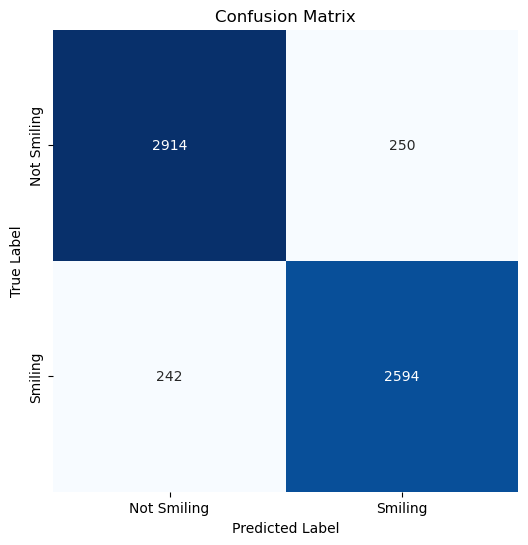

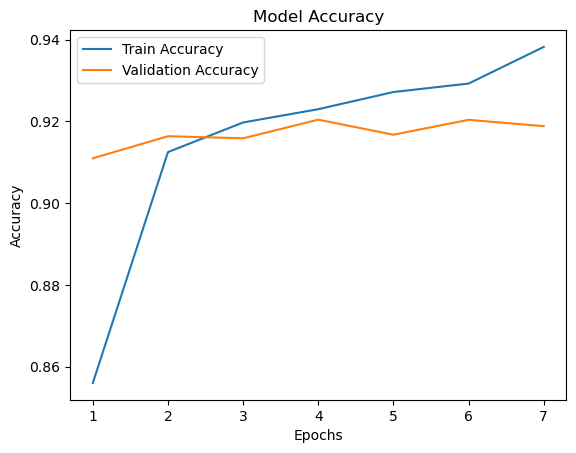

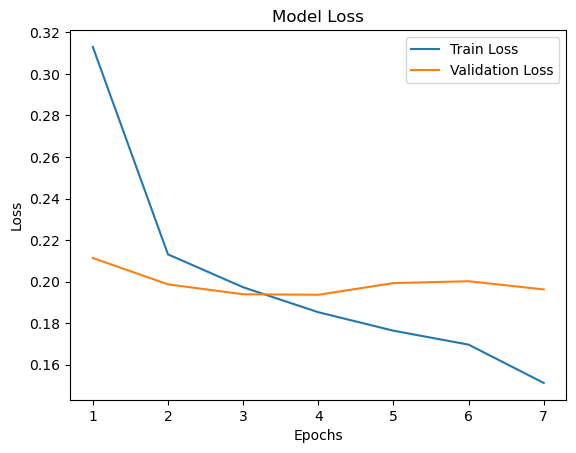

In [ ]:
#CNN model with three convolutional layers
try:
    model_pipeline(labeled_images_df.collect(), create_three_conv_cnn_model)
except Exception as e:
    print("An error occurred:", e)

#---Evaluation metrics---
#Final Training Loss:           0.15
#Final Training Accuracy:       0.94
#Final Validation Loss:         0.20
#Final Validation Accuracy:     0.92
#Out-Of-Sample Test Accuracy:   0.92
#Accuracy training curve:       Shows training improving faster than validation 
#                                   and slight divergence at the final epochs
#Loss training curve:           Shows the model is overfitting
#Confusion matrix:              Shows high per class accucacy
#Overall findings: Good model results but it is overfitting and can be improved

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 242s 437ms/step - accuracy: 0.7749 - loss: 0.4283 - val_accuracy: 0.9107 - val_loss: 0.2135 - learning_rate: 0.0010
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 240s 440ms/step - accuracy: 0.9153 - loss: 0.2068 - val_accuracy: 0.9175 - val_loss: 0.1971 - learning_rate: 0.0010
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 240s 439ms/step - accuracy: 0.9198 - loss: 0.1924 - val_accuracy: 0.9203 - val_loss: 0.1899 - learning_rate: 0.0010
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 238s 436ms/step - accuracy: 0.9269 - loss: 0.1792 - val_accuracy: 0.9194 - val_loss: 0.1937 - learning_rate: 0.0010
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9280 - loss: 0.1723
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
546/546 ━━━━━━━━━━━━━━━━━━━━ 237s 434ms/step - accuracy: 0.9280 - loss: 0.1723 - val_accuracy: 0.9183 - val_loss: 0.1935 - learning_rate: 0.0010
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 232s 425ms/step - accuracy:

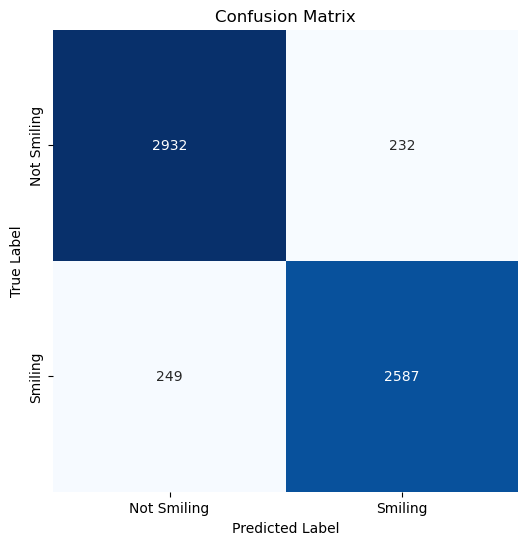

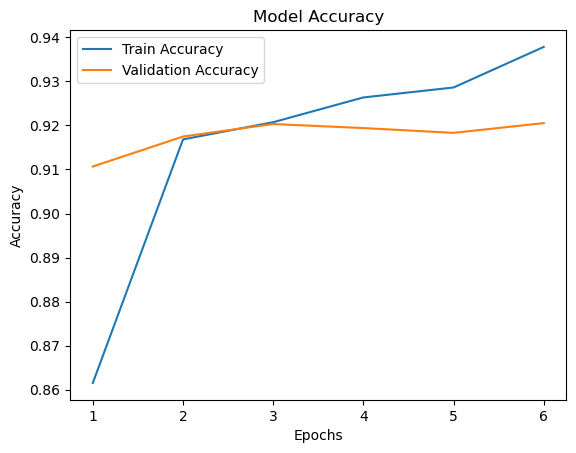

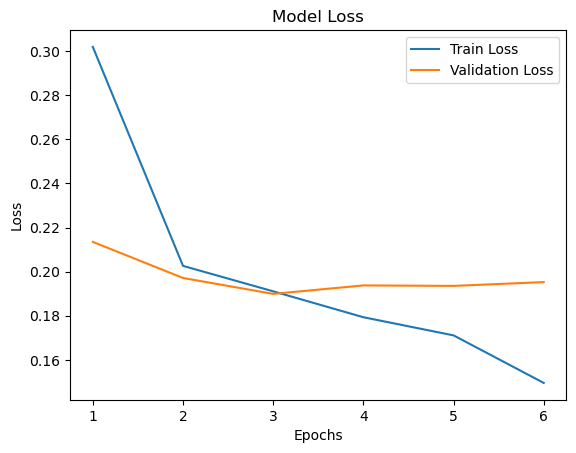

In [ ]:
#CNN model with four convolutional layers
try:
    model_pipeline(labeled_images_df.collect(), create_four_conv_cnn_model)
except Exception as e:
    print("An error occurred:", e)

#---Evaluation metrics---
#Final Training Loss:           0.15
#Final Training Accuracy:       0.94
#Final Validation Loss:         0.20
#Final Validation Accuracy:     0.92
#Out-Of-Sample Test Accuracy:   0.92
#Accuracy training curve:       Shows training improving faster than validation 
#                                   and slight divergence at the final epochs
#Loss training curve:           Shows the model is overfitting
#Confusion matrix:              Shows high per class accucacy
#Overall findings: Good model results but it is overfitting and can be improved

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 250s 451ms/step - accuracy: 0.7229 - loss: 0.4939 - val_accuracy: 0.9149 - val_loss: 0.2070 - learning_rate: 0.0010
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 245s 449ms/step - accuracy: 0.9120 - loss: 0.2147 - val_accuracy: 0.9169 - val_loss: 0.1962 - learning_rate: 0.0010
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 242s 443ms/step - accuracy: 0.9203 - loss: 0.1923 - val_accuracy: 0.9182 - val_loss: 0.2026 - learning_rate: 0.0010
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 241s 441ms/step - accuracy: 0.9238 - loss: 0.1829 - val_accuracy: 0.9191 - val_loss: 0.1952 - learning_rate: 0.0010
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 240s 440ms/step - accuracy: 0.9271 - loss: 0.1743 - val_accuracy: 0.9205 - val_loss: 0.1980 - learning_rate: 0.0010
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9293 - loss: 0.1667
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
546/546 ━━━━━━━━━━━━━━━━━━━━ 235s 431ms/step - accuracy:

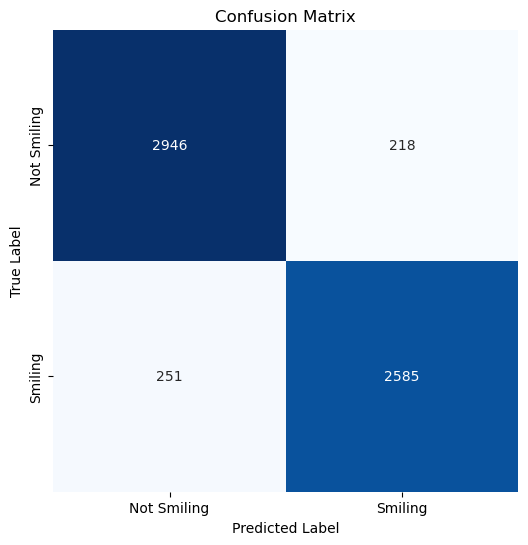

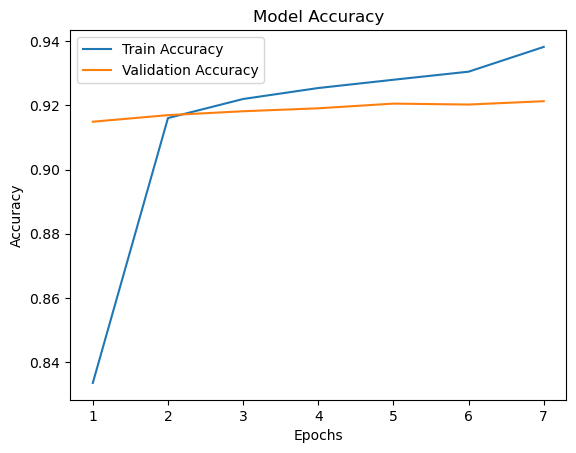

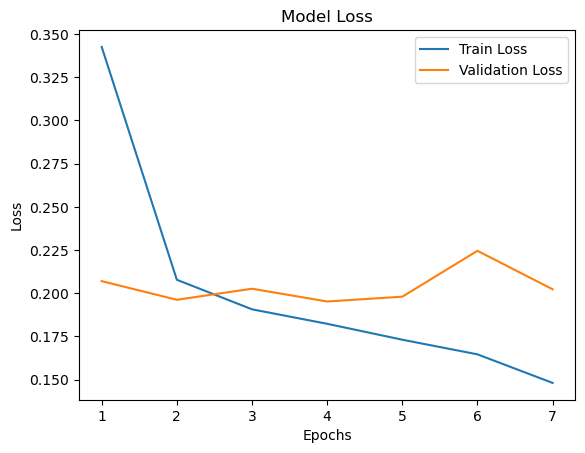

In [ ]:
#CNN model with five convolutional layers
try:
    model_pipeline(labeled_images_df.collect(), create_five_conv_cnn_model)
except Exception as e:
    print("An error occurred:", e)

#---Evaluation metrics---
#Final Training Loss:           0.15
#Final Training Accuracy:       0.94
#Final Validation Loss:         0.20
#Final Validation Accuracy:     0.92
#Out-Of-Sample Test Accuracy:   0.92
#Accuracy training curve:       Shows training improving faster than validation 
#                                   and slight divergence at the final epochs
#Loss training curve:           Shows the model is overfitting
#Confusion matrix:              Shows high per class accucacy
#Overall findings: Good model results but it is overfitting and can be improved

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 254s 458ms/step - accuracy: 0.7073 - loss: 0.7046 - val_accuracy: 0.9031 - val_loss: 0.2943 - learning_rate: 0.0010
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 241s 443ms/step - accuracy: 0.9008 - loss: 0.3028 - val_accuracy: 0.9052 - val_loss: 0.2791 - learning_rate: 0.0010
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 241s 441ms/step - accuracy: 0.9106 - loss: 0.2769 - val_accuracy: 0.9104 - val_loss: 0.2648 - learning_rate: 0.0010
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 239s 438ms/step - accuracy: 0.9127 - loss: 0.2652 - val_accuracy: 0.9159 - val_loss: 0.2495 - learning_rate: 0.0010
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 238s 436ms/step - accuracy: 0.9169 - loss: 0.2551 - val_accuracy: 0.9139 - val_loss: 0.2564 - learning_rate: 0.0010
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9156 - loss: 0.2572
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
546/546 ━━━━━━━━━━━━━━━━━━━━ 234s 429ms/step - accuracy:

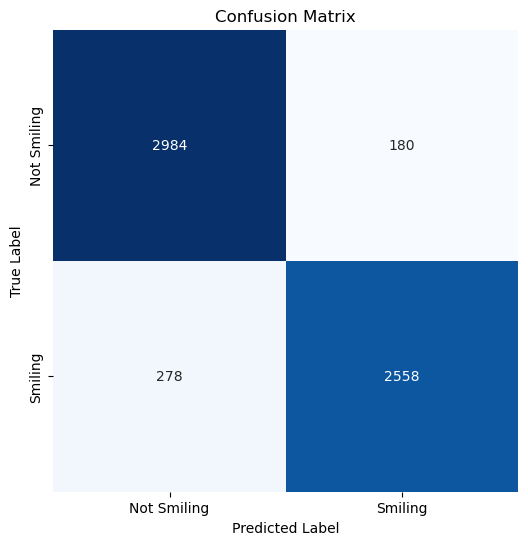

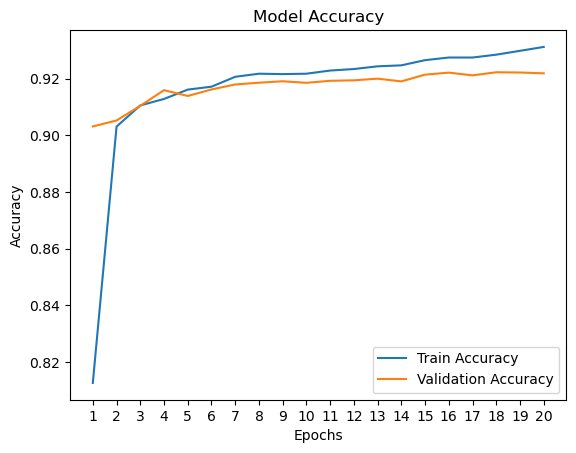

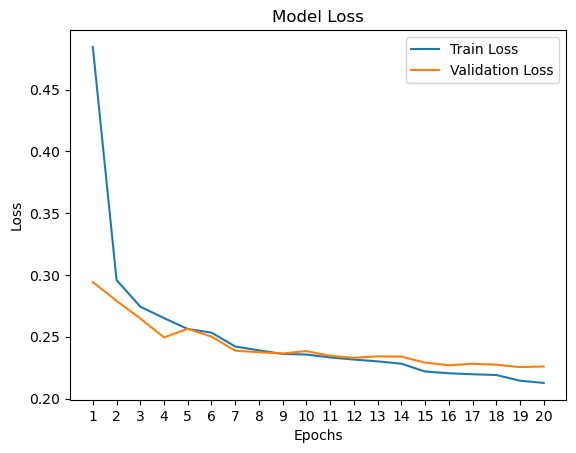

In [ ]:
#CNN model with four convolutional layers and regularisation
#Regulerisation is explained in detail and justified in the accompanying PDF document
try:
    model_pipeline(labeled_images_df.collect(), create_four_conv_cnn_model_with_regularisation)
except Exception as e:
    print("An error occurred:", e)

#---Evaluation metrics---
#Final Training Loss:           0.21
#Final Training Accuracy:       0.93
#Final Validation Loss:         0.23
#Final Validation Accuracy:     0.92
#Out-Of-Sample Test Accuracy:   0.92
#Accuracy training curve:       Shows training and validation converging and improving similarly
#Loss training curve:           Shows the model is not under or overfitting
#Confusion matrix:              Shows high per class accucacy
#Overall findings: Good model results with no overfitting, can posisbly be slightly improved

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 336s 607ms/step - accuracy: 0.6745 - loss: 0.7477 - val_accuracy: 0.8895 - val_loss: 0.3297 - learning_rate: 0.0010
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 262s 480ms/step - accuracy: 0.9032 - loss: 0.3090 - val_accuracy: 0.9134 - val_loss: 0.2692 - learning_rate: 0.0010
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 260s 477ms/step - accuracy: 0.9113 - loss: 0.2791 - val_accuracy: 0.9172 - val_loss: 0.2536 - learning_rate: 0.0010
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 260s 477ms/step - accuracy: 0.9143 - loss: 0.2673 - val_accuracy: 0.9163 - val_loss: 0.2525 - learning_rate: 0.0010
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 256s 469ms/step - accuracy: 0.9181 - loss: 0.2615 - val_accuracy: 0.9199 - val_loss: 0.2493 - learning_rate: 0.0010
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 252s 461ms/step - accuracy: 0.9189 - loss: 0.2582 - val_accuracy: 0.9187 - val_loss: 0.2495 - learning_rate: 0.0010
Epoch 7/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy

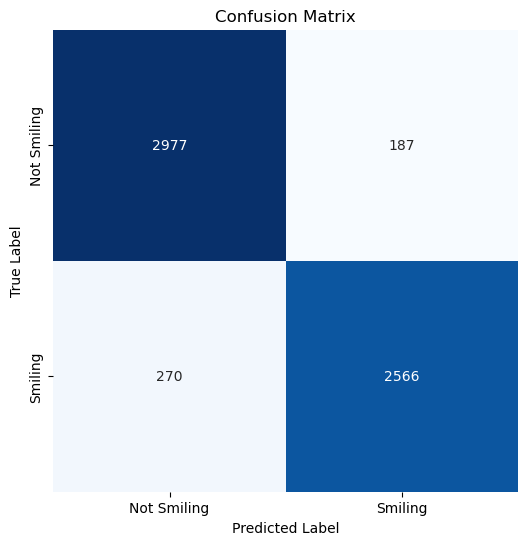

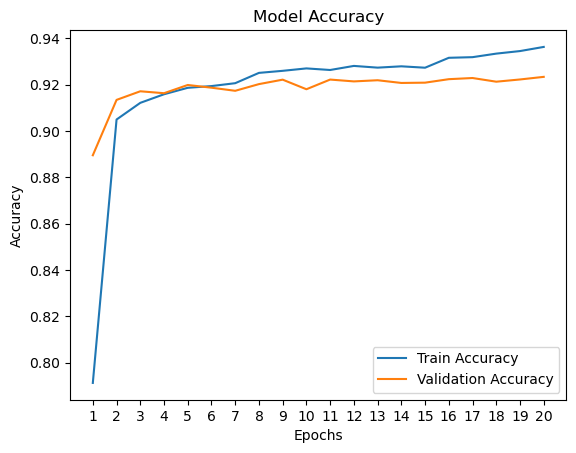

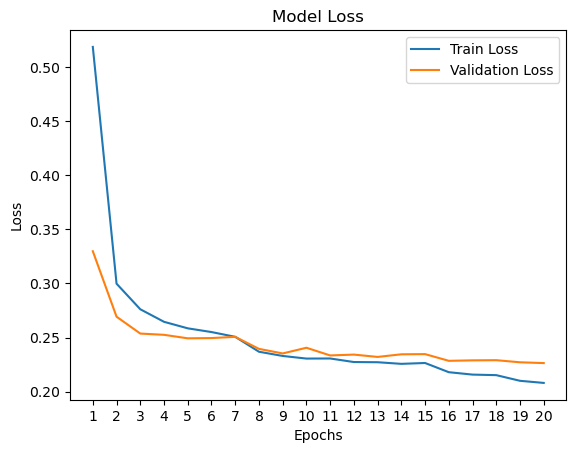

In [ ]:
#CNN model with four convolutional and two fully connected layers and regularisation
try:
    model_pipeline(labeled_images_df.collect(), create_duel_layered_cnn_model_with_regularisation)
except Exception as e:
    print("An error occurred:", e)

#---Evaluation metrics---
#Final Training Loss:           0.22
#Final Training Accuracy:       0.93
#Final Validation Loss:         0.23
#Final Validation Accuracy:     0.92
#Out-Of-Sample Test Accuracy:   0.92
#Accuracy training curve:       Shows training and validation converging and moving very similarly
#Loss training curve:           Shows the model is not under or overfitting, shows very good convergence
#                                   Shows that at the final epoch there was minor divergence 
#Confusion matrix:              Shows high per class accucacy
#Overall findings: Good model results with no problems, can possibly be improved slightly

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 266s 480ms/step - accuracy: 0.5748 - loss: 0.8890 - val_accuracy: 0.7088 - val_loss: 0.6239 - learning_rate: 0.0010
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 258s 473ms/step - accuracy: 0.7486 - loss: 0.5640 - val_accuracy: 0.8568 - val_loss: 0.4056 - learning_rate: 0.0010
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 261s 478ms/step - accuracy: 0.8476 - loss: 0.4315 - val_accuracy: 0.8649 - val_loss: 0.3849 - learning_rate: 0.0010
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 261s 477ms/step - accuracy: 0.8668 - loss: 0.3927 - val_accuracy: 0.8910 - val_loss: 0.3353 - learning_rate: 0.0010
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 255s 468ms/step - accuracy: 0.8770 - loss: 0.3741 - val_accuracy: 0.8928 - val_loss: 0.3289 - learning_rate: 0.0010
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 250s 458ms/step - accuracy: 0.8808 - loss: 0.3624 - val_accuracy: 0.8970 - val_loss: 0.3225 - learning_rate: 0.0010
Epoch 7/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 238s 437ms/step - accura

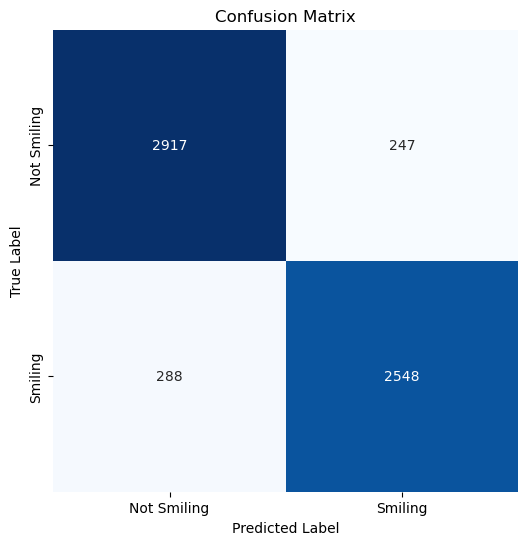

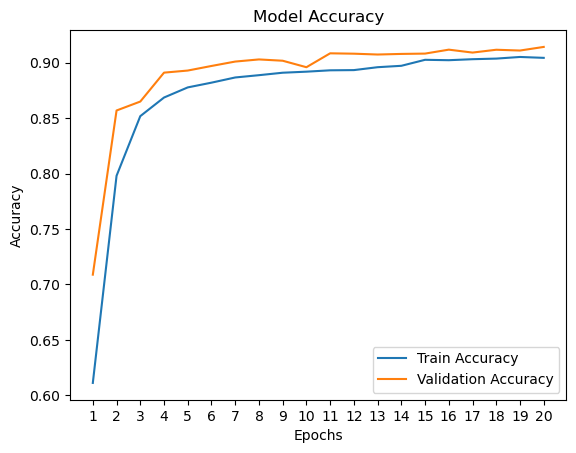

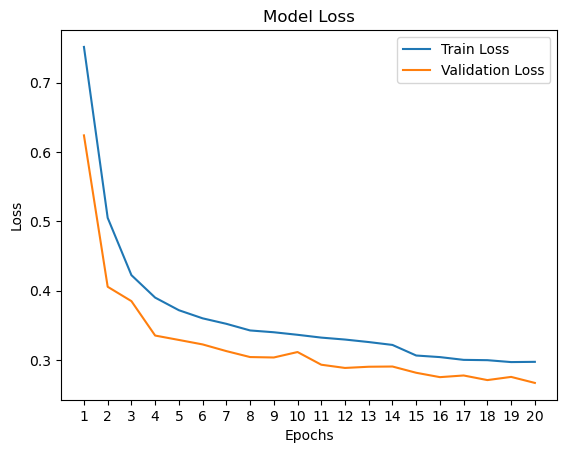

In [ ]:
#CNN model with four convolutional and two fully connected layers with regularisation and augmentation
#The defintion, justifications and rational for data augmentation is in the accompanying PDF document
try:
    model_pipeline(labeled_images_df.collect(), create_four_conv_cnn_model_with_augmentation_and_regularization)
except Exception as e:
    print("An error occurred:", e)

#---Evaluation metrics---
#Final Training Loss:           0.30
#Final Training Accuracy:       0.90
#Final Validation Loss:         0.27
#Final Validation Accuracy:     0.91
#Out-Of-Sample Test Accuracy:   0.91
#Accuracy training curve:       Shows the training and validation accuracies moved together closely
#                                   Shows very good convergence
#Loss training curve:           Shows the training and validation losses closely followed one another
#                                   Shows very good convergence with no overfitting or underfitting
#Confusion matrix:              Shows a very accurate model with good generaliation abilities
#Overall findings: A accurate model with good results on all metrics, 
#                      possibly with more iterations it may be more accurate

In [ ]:
###############################################################################################################################################################
#----------------------------------------------------------------------ADDITIONAL MODELS-----------------------------------------------------------------------
###############################################################################################################################################################

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 310s 6s/step - accuracy: 0.6029 - loss: 1.5724 - val_accuracy: 0.8083 - val_loss: 1.0679 - learning_rate: 1.0000e-04
Epoch 2/20
24/54 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8413 - loss: 1.0035

c:\Users\cybrm\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


54/54 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - accuracy: 0.8390 - loss: 0.9887 - val_accuracy: 0.8443 - val_loss: 0.9041 - learning_rate: 1.0000e-04
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 312s 6s/step - accuracy: 0.8657 - loss: 0.8185 - val_accuracy: 0.8696 - val_loss: 0.7034 - learning_rate: 1.0000e-04
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 267s 5s/step - accuracy: 0.9088 - loss: 0.5950 - val_accuracy: 0.8770 - val_loss: 0.6545 - learning_rate: 1.0000e-04
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 320s 6s/step - accuracy: 0.9254 - loss: 0.5125 - val_accuracy: 0.8791 - val_loss: 0.5672 - learning_rate: 1.0000e-04
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 269s 5s/step - accuracy: 0.9438 - loss: 0.3970 - val_accuracy: 0.8670 - val_loss: 0.5447 - learning_rate: 1.0000e-04
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 318s 6s/step - accuracy: 0.9651 - loss: 0.3242 - val_accuracy: 0.8799 - val_loss: 0.5353 - learning_rate: 1.0000e-04
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 264s 5s/step - accuracy: 0.9805 - loss: 0.2

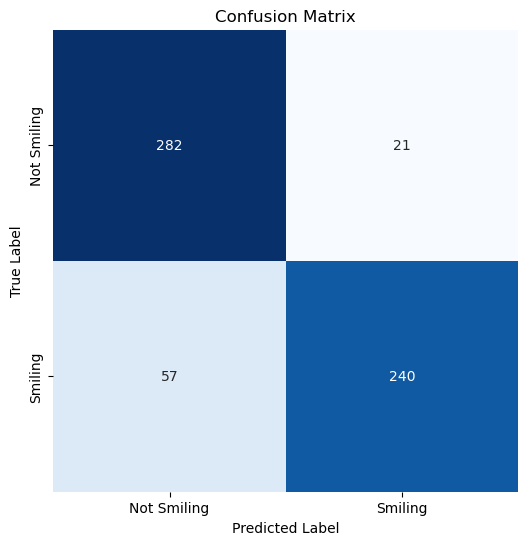

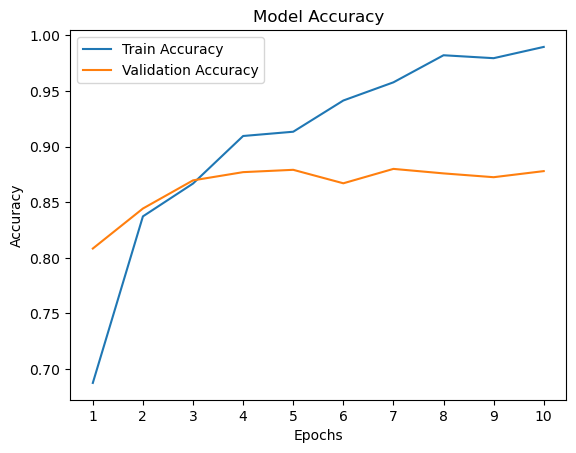

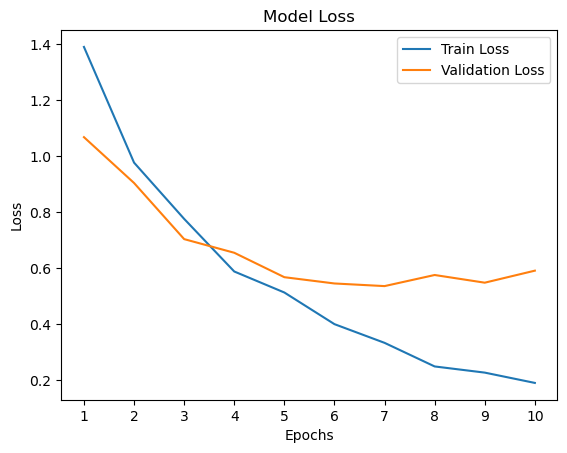

In [ ]:
#Transfer learning model
#This model was not included in the Pipeline as it required different processes and steps.
#The justifications, rational and definition of transfer learning can be found in the accompanying PDF document

#Get the three datasets
train_dataset, val_dataset, test_dataset = create_tf_datasets(data=labeled_images_df.collect())
#Due to the computational cost of the model it can only take 10,000 entries, more and the model will take 7-10 hours to train
train_dataset = train_dataset.take(10000 // 128)

#Declare callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#Load the VGG16 image classification model from TensorFlow
#A description of the VGG16 image classification model can be found in the accompanying PDF document
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

#Disable re-training in the model, with the exeption of the last four layers 
base_model.trainable = False
for layer in base_model.layers[-4:]: 
    layer.trainable = True

#Define steps per epoch as the data is repeating
steps_per_epoch = int((10000*0.7) // 128)
val_steps_per_epoch = int(((sampling_count*0.3)*0.8) // 128)

#Define the model, add a fully connected layer and an output layer
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

#Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Train the model and pass it its paramiters
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=20, 
    batch_size=128, 
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    callbacks=[lr_scheduler, early_stopping])

#Evaluate the model
evaluate_model(model, test_dataset, history)

#---Evaluation metrics---
#Final Training Loss:           0.19
#Final Training Accuracy:       0.99
#Final Validation Loss:         0.59
#Final Validation Accuracy:     0.87
#Out-Of-Sample Test Accuracy:   0.87
#Accuracy training curve:       Shows bad overfitting with poor validation accuracy
#Loss training curve:           Shows bad overfitting with poor validation loss
#Confusion matrix:              Shows a accurate model with good generaliation abilities
#Overall findings: This model overfits serverly, which is why multiple evaluation metrics are needed

In [ ]:
###############################################################################################################################################################
#----------------------------------------------------------------------USER INPUT------------------------------------------------------------------------------
###############################################################################################################################################################

Model loaded


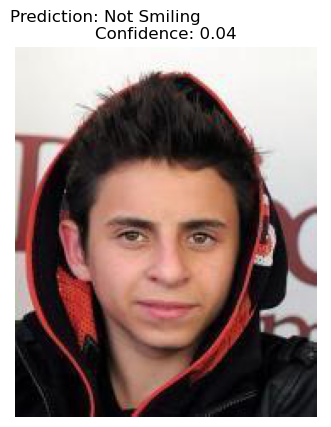

In [ ]:
#User input
#Tries to use alot of try-catches as code will break when dealing with user inputs
#The logic is the same as the logic used in the pipeline, get a file path, process it, give it to the model, evaluate

#An interesting problem found when testing the user input, was that it was very inaccurate with images not taken from the same origin dataset (images not used in the 100,000 used to train, validation and test). 
#With more time to test and play with the code and the images it may be possible to figure out why this is. 
#The leading hypothesis is that it is the image properties such as dimensions, aspect ratio, resolution and zoom on the person that causes the problems. Thus it is recommended to use the default option.
#As the user input was included as a cool and interesting extra addition and not part of the assignments instructions this problem was not explored further.

#Try load model
try:
    #Load model
    model = load_model('ST10081881_best_model.keras')
    print("Model loaded")
    error = False #used to tell the code if the image is valid or not

    #Try to get the image file path
    try:
        #Get a random image from outside the range used in any of the models
        random_image_ID = random.randint(110000, 200000)
        default_path = f"images\{random_image_ID}.jpg" 

        #Ask the user for an image path
        file_path = input(f"Enter the path to a .jpg image (enter nothing if you with to use a random image):").strip()

        #If not file path was given use the default path
        if not file_path:  
            file_path = default_path
        #If a file path was given ensure it is a jpg
        if not file_path.endswith('.jpg'):
            print("Error: Please use a jpg image.")
            error = True
        
        #If the file path is valid use it
        if error == False:
            #Load and process the image in the same manner that the images used in the pipeline are
            img = tf.io.read_file(file_path)
            img = tf.io.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, [128, 128]) 
            img = img / 255.0  
            
            #Predict using imported model
            img_array = tf.expand_dims(img, axis=0) #A third dimension needs to be added for image classification
            prediction = model(img_array, training=False)
            prediction = prediction.numpy().flatten()[0] #Get the first result
            
            #Display image and predicted class
            plt.imshow(np.array(Image.open(file_path)))
            plt.axis('off')
            plt.title(f"Prediction: {'Smiling' if prediction > 0.5 else 'Not Smiling'} \
                      \nConfidence: {prediction:.2f}")
            plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")
except Exception as e:
    print("Error loading model:", e)